In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, regularizers
from tqdm import tqdm # Import tqdm for progress bars
import librosa # Import librosa for audio processing
import random


In [3]:
# --- Reproducibility Seed ---
# Setting a random seed ensures that results are reproducible across runs.
# This means that operations involving randomness (like train-test splits,
# neural network weight initialization, and shuffling in datasets) will
# produce the same output each time the code is executed with the same seed.
SEED = 42 # You can change this number to any integer for different random sequences
tf.random.set_seed(SEED) # Seed for TensorFlow operations
np.random.seed(SEED)     # Seed for NumPy operations
random.seed(SEED)        # Seed for Python's built-in random module

In [4]:
# --- Configuration ---
# Defines global parameters for data processing and model building.
DATA_DIR    = "archive/Data/genres_original"  # Directory containing your unzipped GTZAN audio files
SPEC_DIR    = "data/spec_128"         # Directory where generated Mel spectrograms (.npy files) will be saved
SAMPLE_RATE = 22050                   # Uniform sampling rate for audio files (samples per second)
DURATION    = 30                      # Duration in seconds to load per track (e.g., first 30 seconds)
N_MELS      = 128                     # Number of Mel bands to generate in the spectrogram
HOP_LENGTH  = 512                     # The number of samples between successive frames in spectrogram calculation
TARGET_T    = 128                     # Target number of time frames for padding/trimming spectrograms

# Ensure output directories exist. If they don't, they will be created.
os.makedirs(SPEC_DIR, exist_ok=True)

In [5]:

# --- Spectrogram Generation ---
# This section processes raw audio files into Mel spectrograms and saves them as .npy files.
# It iterates through each genre, loads WAV files, computes their Mel spectrograms,
# converts them to a decibel scale, and saves them. Error handling is included.

failed_files = [] # List to store paths of files that failed to process
print("--- Generating Spectrograms ---")
for genre in os.listdir(DATA_DIR):
    in_genre  = os.path.join(DATA_DIR, genre)  # Input path for current genre's audio files
    out_genre = os.path.join(SPEC_DIR, genre) # Output path for current genre's spectrograms
    os.makedirs(out_genre, exist_ok=True)     # Ensure output directory for this genre exists

    for fname in tqdm(os.listdir(in_genre), desc=f"Spectrograms → {genre}"):
        if not fname.lower().endswith(".wav"):
            continue # Skip non-WAV files

        path = os.path.normpath(os.path.join(in_genre, fname)) # Full path to the current audio file
        try:
            # Load audio file: `y` is the audio time series, `sr` is the sampling rate
            y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True, duration=DURATION)
            # Compute Mel spectrogram: Converts audio to a Mel-frequency spectrogram
            S      = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
            # Convert power spectrogram to decibel (dB) scale for better human perception
            S_db   = librosa.power_to_db(S, ref=np.max)

            # --- FIX: Pad/Trim spectrogram to TARGET_T ---
            # librosa.util.fix_length pads or trims the input array (spectrogram's time axis)
            # to the desired length (TARGET_T), ensuring consistent input shape for the model.
            S_db_fixed = librosa.util.fix_length(S_db, size=TARGET_T, axis=1) # Fix length along the time axis (axis=1)

            # Save the processed spectrogram as a .npy file in the specified output directory
            np.save(os.path.join(out_genre, fname.replace(".wav", ".npy")), S_db_fixed)
        except Exception as e:
            # Catch and report any errors during processing
            print(f"Failed {path}: {e}")
            failed_files.append(path)
            continue

print(f"\nFinished Spectrogram Generation. Skipped {len(failed_files)} files.\n")

--- Generating Spectrograms ---


Spectrograms → rock: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Finished Spectrogram Generation. Skipped 0 files.



In [6]:
# --- Prepare File Paths & Labels ---
# This section identifies all generated spectrogram files, collects their paths and
# assigns a numerical label to each based on its genre. The data is then split
# into training and testing sets while maintaining the proportion of each genre.

GENRES = sorted(os.listdir(SPEC_DIR)) # Get a sorted list of all genre names from the spectrogram directory

file_paths = [] # List to store paths of all .npy spectrogram files
labels     = [] # List to store corresponding numerical labels for each file

# Iterate through each genre directory
for idx, genre in enumerate(GENRES):
    genre_dir = os.path.join(SPEC_DIR, genre)
    # Iterate through each .npy file (spectrogram) within the genre directory
    for fname in os.listdir(genre_dir):
        if fname.endswith(".npy"):
            # Append the full path to the spectrogram file
            file_paths.append(os.path.join(genre_dir, fname))
            # Append the numerical label (index) corresponding to the genre
            labels.append(idx)

# Convert lists to NumPy arrays for efficient data manipulation in subsequent steps
file_paths = np.array(file_paths)
labels     = np.array(labels)

# Train/test split: Splits the dataset into training and testing sets.
# test_size=0.2: 20% of the data will be used for testing, 80% for training.
# random_state=42: Ensures reproducibility of the split.
# stratify=labels: Ensures that the proportion of each genre is maintained in both the training and testing sets.
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)




In [7]:
# Convert lists to NumPy arrays for efficient data manipulation in subsequent steps
file_paths = np.array(file_paths)
labels     = np.array(labels)

In [8]:
# Train/test split: Splits the dataset into training and testing sets.
# test_size=0.2: 20% of the data will be used for testing, 80% for training.
# random_state=42: Ensures reproducibility of the split.
# stratify=labels: Ensures that the proportion of each genre is maintained in both the training and testing sets.
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [9]:
# --- Data Loading (TensorFlow Dataset) ---
# This section defines functions to efficiently load spectrogram data into TensorFlow datasets.
# It includes pre-processing steps like loading .npy files, adding a channel dimension,
# and normalizing the data. Crucially, it handles the conversion from TensorFlow EagerTensors
# to Python strings for numpy operations and sets static shapes for model compatibility.
def load_spectrogram(path, label):
    """
    Loads a spectrogram from a .npy file, adds a channel dimension,
    normalizes it, and returns it along with its label.
    This function is designed to be used within a tf.py_function.

    Args:
        path (tf.Tensor): TensorFlow EagerTensor representing the file path (bytes).
                          It needs to be converted to a Python string for np.load.
        label (tf.Tensor): TensorFlow EagerTensor representing the label (int).

    Returns:
        tuple: (spectrogram_data (np.float32), label (np.int32))
    """
    # Convert the EagerTensor path (which is bytes) to a Python string before passing to np.load
    spec = np.load(path.numpy().decode("utf-8"))
    # Add channel dimension: Spectrograms are 2D (N_MELS, TARGET_T), CNNs expect (Height, Width, Channels).
    # Here, we add a single channel dimension, making it (N_MELS, TARGET_T, 1).
    spec = spec[..., np.newaxis]
    # Normalize pixel values to the [0,1] range, which is beneficial for neural network training.
    # Adding a small epsilon (1e-6) to the denominator to prevent division by zero if max and min are the same.
    spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-6)
    return spec.astype(np.float32), np.int32(label) # Ensure data types are float32 for spec and int32 for label

def wrap_load(path, label):
    """
    Wrapper function for tf.py_function to load spectrograms and set static shapes.
    Setting static shapes is crucial for the Keras model to build correctly,
    as `tf.py_function` initially returns tensors with unknown shapes.

    Args:
        path (tf.Tensor): TensorFlow EagerTensor representing the file path.
        label (tf.Tensor): TensorFlow EagerTensor representing the label.

    Returns:
        tuple: (spectrogram_data (tf.float32), label (tf.int32)) with static shapes.
    """
    # Use tf.py_function to wrap the numpy-based `load_spectrogram` function.
    # This allows non-TensorFlow operations (like np.load) to be included in the TensorFlow graph.
    spec, lbl = tf.py_function(load_spectrogram, [path, label], [tf.float32, tf.int32])
    # Explicitly set static shapes for the spectrogram and label.
    # This informs Keras about the expected input dimensions, allowing it to build the model layers.
    spec.set_shape([N_MELS, TARGET_T, 1]) # Spectrogram shape derived from configuration
    lbl.set_shape([]) # Labels are scalar values
    return spec, lbl

def make_dataset(paths, labels, batch_size=32, shuffle=True):
    """
    Creates a TensorFlow Dataset from file paths and labels for efficient data loading during training.

    Args:
        paths (np.array): Array of file paths to the spectrograms.
        labels (np.array): Array of corresponding numerical labels.
        batch_size (int): The number of samples per batch.
        shuffle (bool): If True, the dataset will be shuffled.

    Returns:
        tf.data.Dataset: Configured TensorFlow Dataset ready for training/evaluation.
    """
    # Create a dataset from slices of the file paths and labels
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        # Shuffle the dataset. `reshuffle_each_iteration=True` ensures the dataset is shuffled
        # differently at the start of each epoch, which is good for training stability.
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    # Apply the `wrap_load` function to each element in the dataset.
    # `num_parallel_calls=tf.data.AUTOTUNE` allows TensorFlow to automatically determine the number
    # of elements to process in parallel, optimizing data loading performance.
    ds = ds.map(wrap_load, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch the elements and prefetch a certain number of batches.
    # Prefetching overlaps data preprocessing and model execution, reducing idle time.
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [10]:
# Create training and testing datasets using the `make_dataset` function
batch_size = 32
train_ds = make_dataset(train_paths, train_labels, batch_size, shuffle=True)
test_ds  = make_dataset(test_paths,  test_labels,  batch_size, shuffle=False)



In [11]:
# Assuming 'train_ds' or 'test_ds' is the _PrefetchDataset you want to inspect

print("--- Inspecting the Dataset ---")
for i, (spectrogram_batch, label_batch) in enumerate(train_ds.take(2)): # Take 2 batches for inspection
    print(f"\nBatch {i+1}:")
    print(f"  Spectrograms batch shape: {spectrogram_batch.shape}")
    print(f"  Labels batch shape: {label_batch.shape}")

    # Optionally, inspect the first spectrogram and label in this batch
    if spectrogram_batch.shape[0] > 0:
        print(f"  Shape of first spectrogram in batch: {spectrogram_batch[0].shape}")
        print(f"  Value of first label in batch: {label_batch[0].numpy()}")
    else:
        print("  Batch is empty.")

    if i == 1: # Stop after inspecting 2 batches
        break

print("\n--- End of Dataset Inspection ---")

--- Inspecting the Dataset ---

Batch 1:
  Spectrograms batch shape: (32, 128, 128, 1)
  Labels batch shape: (32,)
  Shape of first spectrogram in batch: (128, 128, 1)
  Value of first label in batch: 5

Batch 2:
  Spectrograms batch shape: (32, 128, 128, 1)
  Labels batch shape: (32,)
  Shape of first spectrogram in batch: (128, 128, 1)
  Value of first label in batch: 7

--- End of Dataset Inspection ---


In [12]:
# Assuming 'train_ds' or 'test_ds' is the _PrefetchDataset you want to inspect

print("--- Inspecting the Dataset ---")
for i, (spectrogram_batch, label_batch) in enumerate(test_ds.take(2)): # Take 2 batches for inspection
    print(f"\nBatch {i+1}:")
    print(f"  Spectrograms batch shape: {spectrogram_batch.shape}")
    print(f"  Labels batch shape: {label_batch.shape}")

    # Optionally, inspect the first spectrogram and label in this batch
    if spectrogram_batch.shape[0] > 0:
        print(f"  Shape of first spectrogram in batch: {spectrogram_batch[0].shape}")
        print(f"  Value of first label in batch: {label_batch[0].numpy()}")
    else:
        print("  Batch is empty.")

    if i == 1: # Stop after inspecting 2 batches
        break

print("\n--- End of Dataset Inspection ---")

--- Inspecting the Dataset ---

Batch 1:
  Spectrograms batch shape: (32, 128, 128, 1)
  Labels batch shape: (32,)
  Shape of first spectrogram in batch: (128, 128, 1)
  Value of first label in batch: 1

Batch 2:
  Spectrograms batch shape: (32, 128, 128, 1)
  Labels batch shape: (32,)
  Shape of first spectrogram in batch: (128, 128, 1)
  Value of first label in batch: 5

--- End of Dataset Inspection ---


In [13]:
# --- Define & Compile CNN Model ---
# This section constructs the Convolutional Neural Network (CNN) architecture using Keras's
# Sequential API. It then compiles the model by specifying an optimizer, a loss function,
# and metrics to track during training.

num_classes = len(GENRES) # The number of distinct music genres, which is the number of output units.

# Define the CNN model architecture as a sequential stack of layers.
model = models.Sequential([
    # Input layer: Defines the expected shape of the input data (spectrograms).
    # (height, width, channels) -> (N_MELS, TARGET_T, 1) for grayscale-like spectrograms.
    layers.Input(shape=(N_MELS, TARGET_T, 1)),

    # First Convolutional Block with L2 regularization
    # Conv2D: Applies 32 convolutional filters, each 3x3. 'relu' activation for non-linearity.
    # 'padding='same'' ensures the output feature map has the same spatial dimensions as the input.
    layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)), # Reduced L2 strength
    layers.MaxPooling2D(2),         # MaxPooling2D: Reduces spatial dimensions by 2x2 factor, reducing computational cost.
    layers.BatchNormalization(),    # BatchNormalization: Normalizes the activations of the previous layer, stabilizing and accelerating training.

    # Second Convolutional Block with L2 regularization
    layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)), # 64 filters, Reduced L2 strength
    layers.MaxPooling2D(2),
    layers.BatchNormalization(),

    # Third Convolutional Block with L2 regularization
    layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0001)), # 128 filters, Reduced L2 strength
    layers.MaxPooling2D(2),
    layers.BatchNormalization(),

    # Flatten layer: Flattens the 2D feature maps from the convolutional layers into a 1D vector.
    # This prepares the data for input into the fully connected (Dense) layers.
    layers.Flatten(),

    # Dense (Fully Connected) Layers with L2 regularization and increased Dropout
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)), # Reduced L2 strength
    layers.Dropout(0.5),                  # Reduced Dropout rate back to 0.5
    layers.Dense(num_classes, activation='softmax') # Output layer: `num_classes` neurons, one for each genre.
                                                  # 'softmax' activation converts outputs into probability distributions over classes.
])


In [14]:
# Compile the model: Configures the model for training.
model.compile(
    optimizer='adam', # Optimizer: Adam is an adaptive learning rate optimization algorithm.
    loss='sparse_categorical_crossentropy', # Loss function: Used for integer labels when there are two or more label classes.
    metrics=['accuracy'] # Metrics: 'accuracy' is tracked during training and evaluation to assess performance.
)

print("--- Model Summary ---")
model.summary() # Prints a summary of the model architecture, including layer names, output shapes, and parameter counts.




--- Model Summary ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                 

In [15]:
# --- Train Model with Early Stopping ---
# This section configures and initiates the model training process.
# Early Stopping is a callback used to monitor a specific metric (e.g., validation loss)
# and stop training early if no improvement is observed, preventing overfitting and saving training time.

# Define callbacks for training
callbacks = [
    # EarlyStopping callback:
    # monitor='val_loss': The metric to monitor for improvement (validation loss).
    # patience=5: Training will stop if `val_loss` does not improve for 5 consecutive epochs.
    # restore_best_weights=True: The model weights from the epoch with the best `val_loss` will be restored
    #                            at the end of training, ensuring you get the best performing model.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=49, restore_best_weights=True)
]

print("\n--- Training Model ---")
# Train the model using the prepared datasets and defined callbacks.
history = model.fit(
    train_ds,              # The training dataset
    validation_data=test_ds, # The validation dataset, used to monitor performance and guide Early Stopping
    epochs=50,             # Maximum number of training epochs. Training might stop earlier due to EarlyStopping.
    callbacks=callbacks    # List of callbacks to be applied during training
)



--- Training Model ---
Epoch 1/50


25/25 [==============================] - 18s 484ms/step - loss: 5.4929 - accuracy: 0.2203 - val_loss: 2.7494 - val_accuracy: 0.1000
Epoch 2/50
25/25 [==============================] - 9s 345ms/step - loss: 2.4091 - accuracy: 0.2053 - val_loss: 3.0021 - val_accuracy: 0.1000
Epoch 3/50
25/25 [==============================] - 9s 349ms/step - loss: 2.1873 - accuracy: 0.2528 - val_loss: 4.1590 - val_accuracy: 0.1000
Epoch 4/50
25/25 [==============================] - 9s 371ms/step - loss: 2.1331 - accuracy: 0.2390 - val_loss: 5.0775 - val_accuracy: 0.1050
Epoch 5/50
25/25 [==============================] - 9s 359ms/step - loss: 2.1642 - accuracy: 0.2566 - val_loss: 6.0621 - val_accuracy: 0.1000
Epoch 6/50
25/25 [==============================] - 9s 342ms/step - loss: 2.0574 - accuracy: 0.2991 - val_loss: 6.3744 - val_accuracy: 0.1450
Epoch 7/50
25/25 [==============================] - 11s 424ms/step - loss: 1.9782 - accuracy: 0.3292 - val_loss: 7.0315 -

In [16]:
# --- Evaluate Model ---
# This section assesses the trained model's generalization performance on the unseen test dataset.
# It calculates the final loss and accuracy of the model on data it has not seen during training.

print("\n--- Evaluating Model ---")
# Evaluate the model on the test dataset.
# Returns the scalar loss value and the metric values (e.g., accuracy) for the test set.
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")    # Print the final test loss, formatted to 4 decimal places
print(f"Test Accuracy: {accuracy:.4f}") # Print the final test accuracy, formatted to 4 decimal places


--- Evaluating Model ---
7/7 [==============================] - 1s 82ms/step - loss: 2.0460 - accuracy: 0.5250
Test Loss: 2.0460
Test Accuracy: 0.5250



--- Visualizing Training History ---


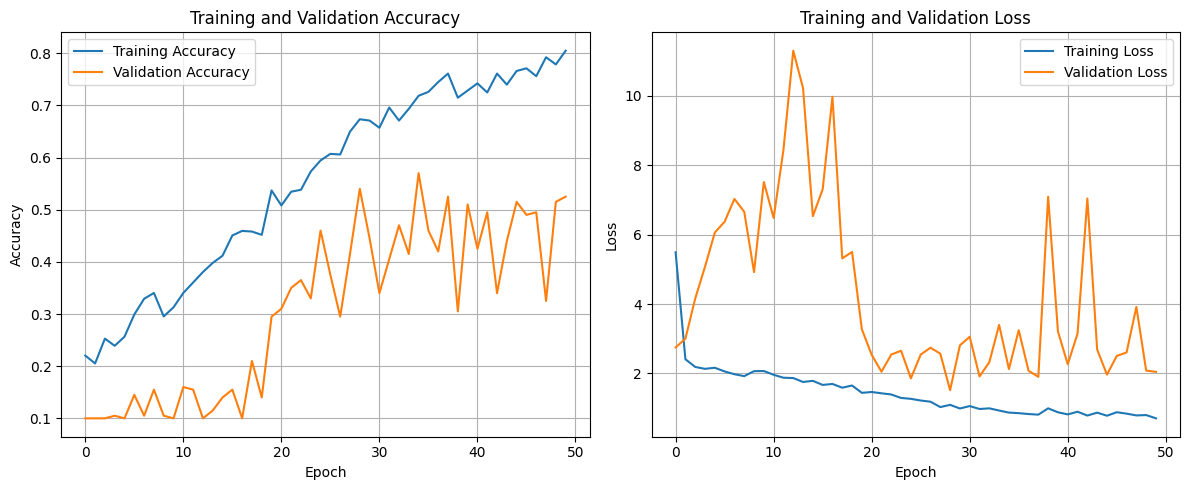

In [17]:
# --- Visualize Training History ---
# This section generates plots to visualize the model's training progression.
# It plots the training and validation accuracy, and training and validation loss over epochs.
# These plots are essential for diagnosing overfitting/underfitting and understanding learning dynamics.

print("\n--- Visualizing Training History ---")
plt.figure(figsize=(12, 5)) # Create a figure with a specified size
# Subplot for Training and Validation Accuracy
plt.subplot(1, 2, 1) # Specifies a 1-row, 2-column grid for plots, and this is the first plot.
plt.plot(history.history['accuracy'], label='Training Accuracy') # Plot training accuracy from the history object
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot validation accuracy
plt.title('Training and Validation Accuracy') # Set the title of the subplot
plt.xlabel('Epoch') # Label for the x-axis
plt.ylabel('Accuracy') # Label for the y-axis
plt.legend() # Display the legend to differentiate lines
plt.grid(True) # Add a grid to the plot for better readability

# Subplot for Training and Validation Loss
plt.subplot(1, 2, 2) # This is the second plot in the 1-row, 2-column grid.
plt.plot(history.history['loss'], label='Training Loss') # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss') # Plot validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjusts plot parameters for a tight layout, preventing labels from overlapping
plt.show() # Display the generated plots



--- Generating Classification Report and Confusion Matrix ---
7/7 [==============================] - 1s 92ms/step
Collected 200 true labels.

Classification Report:
              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        20
   classical       0.72      0.90      0.80        20
     country       0.42      0.55      0.48        20
       disco       0.38      0.45      0.41        20
      hiphop       0.75      0.30      0.43        20
        jazz       1.00      0.55      0.71        20
       metal       0.76      0.80      0.78        20
         pop       0.70      0.70      0.70        20
      reggae       0.44      0.20      0.28        20
        rock       0.20      0.40      0.27        20

    accuracy                           0.53       200
   macro avg       0.59      0.53      0.53       200
weighted avg       0.59      0.53      0.53       200


Confusion Matrix:


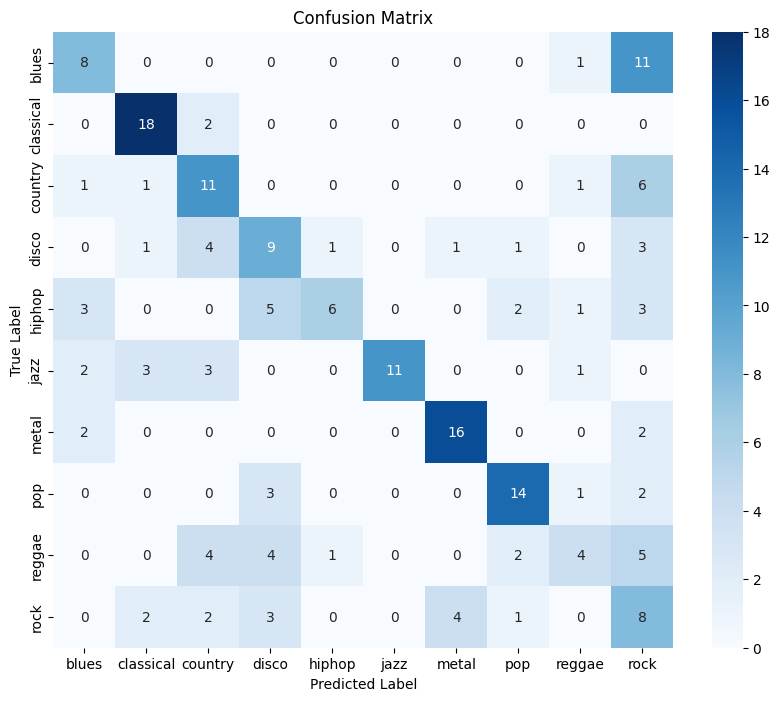

In [18]:
# --- Classification Report and Confusion Matrix ---
# This section provides a comprehensive evaluation of the model's performance on a per-class basis.
# It generates a classification report (precision, recall, f1-score) and a confusion matrix,
# which visually represents the correct and incorrect predictions for each genre.

print("\n--- Generating Classification Report and Confusion Matrix ---")
# Predict probabilities for the test set using the trained model.
# `model.predict` returns the probability distribution over classes for each sample in `test_ds`.
y_pred_probs = model.predict(test_ds)
# Get the predicted class labels by taking the argmax (index of the highest probability)
# for each sample's probability distribution.
y_pred = np.argmax(y_pred_probs, axis=1)

# Retrieve the true labels from the test dataset.
# This approach collects scalar labels into a Python list and then converts to a NumPy array.
print("Collecting true labels from test dataset...")
true_labels_list = []
for _, label_tensor in test_ds.unbatch():
    true_labels_list.append(label_tensor.numpy()) # Convert scalar tensor to Python scalar

if true_labels_list: # Check if the list of collected labels is not empty
    true_labels = np.array(true_labels_list) # Convert the list of scalars to a 1D NumPy array
    print(f"Collected {len(true_labels)} true labels.")

    # Before generating reports, ensure that the number of true labels matches the number of predictions.
    # This check prevents errors if there was an issue in data loading or prediction.
    if len(true_labels) == len(y_pred):
        # Print the Classification Report:
        # Provides precision, recall, f1-score, and support for each class.
        # `target_names=GENRES` ensures that class names are displayed instead of numerical labels.
        print("\nClassification Report:")
        print(classification_report(true_labels, y_pred, target_names=GENRES))

        # Generate and Display the Confusion Matrix:
        # A confusion matrix is a table used to describe the performance of a classification model
        # on a set of test data for which the true values are known.
        print("\nConfusion Matrix:")
        cm = confusion_matrix(true_labels, y_pred) # Calculate the confusion matrix
        plt.figure(figsize=(10, 8)) # Set the figure size for better visual clarity
        # Create a heatmap of the confusion matrix using Seaborn.
        # `annot=True`: Annotate each cell with the numeric value.
        # `fmt='d'`: Format annotations as integers.
        # `cmap='Blues`': Use a blue color map.
        # `xticklabels` and `yticklabels`: Set the labels for the axes using genre names.
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=GENRES, yticklabels=GENRES)
        plt.xlabel('Predicted Label') # Label for the x-axis
        plt.ylabel('True Label')     # Label for the y-axis
        plt.title('Confusion Matrix') # Title of the plot
        plt.show() # Display the confusion matrix plot
    else:
        # If there's a mismatch, print an error message indicating the discrepancy.
        print("Error: Mismatch in length between true labels and predicted labels. Cannot generate classification report and confusion matrix.")
        print(f"True labels length: {len(true_labels)}, Predicted labels length: {len(y_pred)}")
else:
    print("Warning: No true labels were collected from the test dataset. Skipping classification report and confusion matrix generation.")


In [19]:
true_labels_list = []
for _, label_tensor in test_ds.unbatch():
    true_labels_list.append(label_tensor.numpy())

In [20]:
true_labels_list

[1,
 0,
 6,
 5,
 0,
 2,
 9,
 2,
 4,
 5,
 0,
 0,
 8,
 0,
 9,
 3,
 8,
 5,
 3,
 9,
 2,
 6,
 0,
 2,
 0,
 1,
 7,
 8,
 5,
 5,
 6,
 2,
 5,
 4,
 1,
 6,
 9,
 4,
 2,
 3,
 8,
 9,
 7,
 0,
 5,
 5,
 6,
 1,
 4,
 7,
 4,
 6,
 4,
 5,
 8,
 3,
 3,
 1,
 1,
 8,
 6,
 8,
 8,
 9,
 3,
 9,
 9,
 1,
 9,
 7,
 6,
 8,
 1,
 7,
 8,
 4,
 3,
 7,
 7,
 7,
 3,
 7,
 8,
 4,
 5,
 9,
 8,
 4,
 9,
 5,
 6,
 8,
 6,
 3,
 2,
 5,
 5,
 2,
 8,
 8,
 6,
 0,
 8,
 7,
 6,
 9,
 3,
 3,
 6,
 3,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 9,
 8,
 7,
 3,
 0,
 5,
 9,
 8,
 1,
 6,
 4,
 6,
 3,
 6,
 4,
 7,
 5,
 7,
 2,
 3,
 2,
 3,
 8,
 5,
 0,
 3,
 0,
 2,
 4,
 4,
 0,
 1,
 4,
 7,
 1,
 1,
 0,
 9,
 0,
 6,
 5,
 1,
 0,
 3,
 3,
 4,
 5,
 8,
 9,
 9,
 2,
 7,
 0,
 6,
 5,
 0,
 9,
 7,
 1,
 7,
 4,
 2,
 3,
 6,
 4,
 9,
 4,
 1,
 7,
 6,
 2,
 5,
 2,
 4,
 1,
 7,
 7,
 4,
 2,
 2,
 1,
 9,
 2]

In [21]:
true_labels

array([1, 0, 6, 5, 0, 2, 9, 2, 4, 5, 0, 0, 8, 0, 9, 3, 8, 5, 3, 9, 2, 6,
       0, 2, 0, 1, 7, 8, 5, 5, 6, 2, 5, 4, 1, 6, 9, 4, 2, 3, 8, 9, 7, 0,
       5, 5, 6, 1, 4, 7, 4, 6, 4, 5, 8, 3, 3, 1, 1, 8, 6, 8, 8, 9, 3, 9,
       9, 1, 9, 7, 6, 8, 1, 7, 8, 4, 3, 7, 7, 7, 3, 7, 8, 4, 5, 9, 8, 4,
       9, 5, 6, 8, 6, 3, 2, 5, 5, 2, 8, 8, 6, 0, 8, 7, 6, 9, 3, 3, 6, 3,
       0, 0, 1, 2, 1, 2, 1, 9, 8, 7, 3, 0, 5, 9, 8, 1, 6, 4, 6, 3, 6, 4,
       7, 5, 7, 2, 3, 2, 3, 8, 5, 0, 3, 0, 2, 4, 4, 0, 1, 4, 7, 1, 1, 0,
       9, 0, 6, 5, 1, 0, 3, 3, 4, 5, 8, 9, 9, 2, 7, 0, 6, 5, 0, 9, 7, 1,
       7, 4, 2, 3, 6, 4, 9, 4, 1, 7, 6, 2, 5, 2, 4, 1, 7, 7, 4, 2, 2, 1,
       9, 2])

In [22]:

model_save_path = './classifier_app/Genre-Classifier.h5' # Define a directory/file path to save the model
try:
    # Save the model in the native Keras format (recommended for Keras models).
    # This often defaults to a SavedModel-like structure in a directory, but can also be .h5.
    model.save(model_save_path)
    print(f"\nModel saved successfully to: {model_save_path}")
except Exception as e:
    print(f"\nError saving model using model.save(): {e}")

d:\Python_practice\Music-Genre-Classifier\M_genre_classifier\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully to: ./classifier_app/Genre-Classifier.h5
